In [1]:
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import warnings

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt

In [2]:
# Load Training Data

X_data = np.load('TrainMD1.npy')
y_labels = np.load('TrainML1.npy')
print(X_data.shape)
print(y_labels.shape)

(2880, 224, 224, 3)
(2880,)


In [3]:
# Build your model
mobilenet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model1 = Sequential()
model1.add(mobilenet)
model1.add(Flatten())
model1.add(Dense(2, activation='sigmoid'))

model1.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/aynakhil003/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
# Train 

# Prepare your dataset

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)
best_val_acc = 0.0

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_data, y_labels)):
    print(f"Fold: {fold + 1}")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_data[train_indices], X_data[val_indices]
    y_train_fold, y_val_fold = y_labels[train_indices], y_labels[val_indices]

    # Perform one-hot encoding of the labels
    num_classes = 2
    y_train_fold = to_categorical(y_train_fold, num_classes)
    y_val_fold = to_categorical(y_val_fold, num_classes)

    # Define a callback to save the best weights based on validation accuracy improvement
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        f"best_weights_fold{fold + 1}.h5", save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max'
    )
    
    # Define a TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=f"logs/fold{fold + 1}", histogram_freq=1)
    
    # Train the model for 20 epochs
    history = model1.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=32,
        epochs=20,
        callbacks=[checkpoint_callback, tensorboard_callback]
    )

    # Load the best weights based on validation accuracy
    model1.load_weights(f"best_weights_fold{fold + 1}.h5")

    # Evaluate the model on the validation set
    _, val_acc = model1.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy: {val_acc}")

    # Update the best validation accuracy and save the weights if there's an improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model1.save_weights("best_weights.h5")

print("Training complete.")


Fold: 1
Epoch 1/20
72/72 [==============================] - 90s 1s/step - loss: 0.5555 - accuracy: 0.8620 - val_loss: 5.2768 - val_accuracy: 0.6892
Epoch 2/20
72/72 [==============================] - 81s 1s/step - loss: 0.4084 - accuracy: 0.9015 - val_loss: 20.6510 - val_accuracy: 0.6163
Epoch 3/20
72/72 [==============================] - 81s 1s/step - loss: 0.6170 - accuracy: 0.8451 - val_loss: 7.7273 - val_accuracy: 0.5087
Epoch 4/20
72/72 [==============================] - 83s 1s/step - loss: 0.3327 - accuracy: 0.9045 - val_loss: 15.1342 - val_accuracy: 0.4861
Epoch 5/20
72/72 [==============================] - 81s 1s/step - loss: 0.3137 - accuracy: 0.9058 - val_loss: 11.7192 - val_accuracy: 0.5000
Epoch 6/20
72/72 [==============================] - 83s 1s/step - loss: 0.1960 - accuracy: 0.9388 - val_loss: 59.9008 - val_accuracy: 0.5017
Epoch 7/20
72/72 [==============================] - 82s 1s/step - loss: 0.1862 - accuracy: 0.9418 - val_loss: 41.2959 - val_accuracy: 0.5000
Epoch 8

In [9]:
# Load Best Weights

model1.load_weights('best_weights.h5')

In [12]:
# Load NumPy arrays

X_test = np.load('TestMD1.npy')
y_test = np.load('TestML1.npy')

print(X_test.shape)
print(y_test.shape)

(720, 224, 224, 3)
(720,)


In [13]:
# Confusion Matrix

y_test_pred = model1.predict(X_test)
print('Confusion Matrix (5-fold CV): ')
#test_pred1 = np.argmax(y_test_pred, axis=1)
cm1 = confusion_matrix(np.array(y_test_pred).argmax(axis=1), np.array(y_test))
print(cm1)

#Print accuracy
a1 = round(accuracy_score(np.array(y_test), np.array(y_test_pred).argmax(axis=1)),4)*100
print("Accuracy (5-fold CV): {}".format(a1))

#Classification Report
print("Classification Report (5-fold CV): ")
cr1 = classification_report(np.array(y_test), np.array(y_test_pred).argmax(axis=1))
print(cr1)

23/23 [==============================] - 5s 174ms/step
Confusion Matrix (5-fold CV): 
[[353  23]
 [  7 337]]
Accuracy (5-fold CV): 95.83
Classification Report (5-fold CV): 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       360
           1       0.98      0.94      0.96       360

    accuracy                           0.96       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.96      0.96      0.96       720



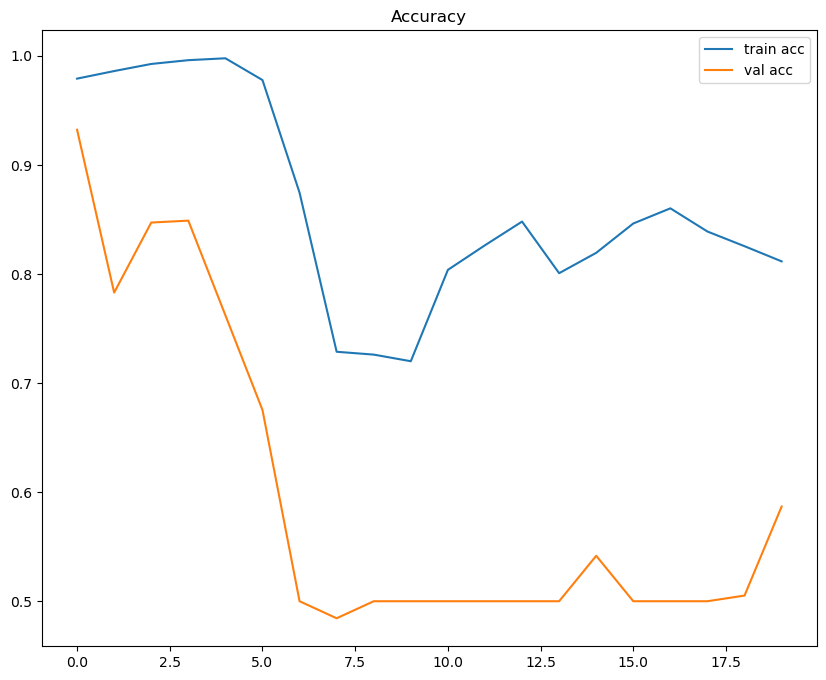

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

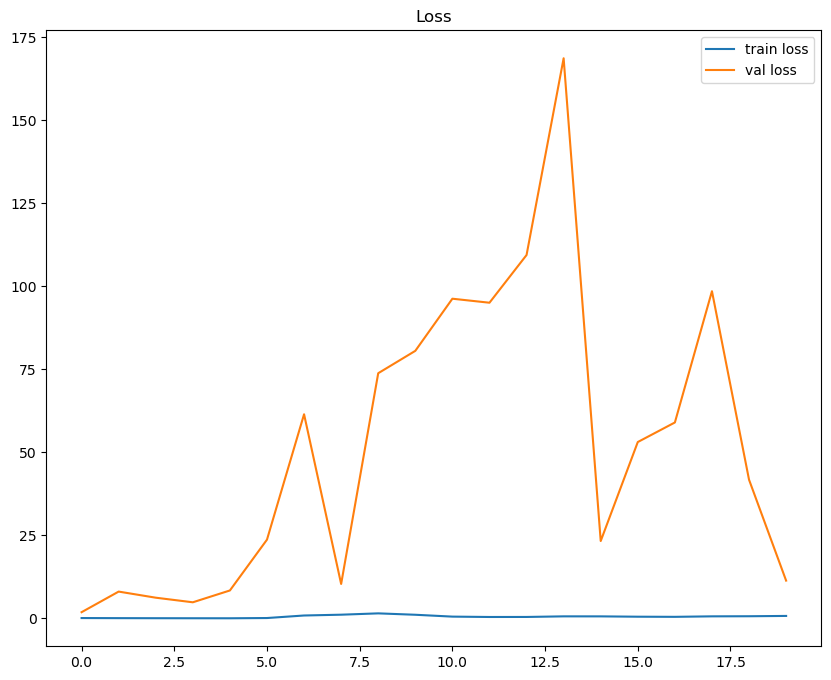

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()